Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.7804 - accuracy: 0.4169
Epoch 1: val_accuracy improved from -inf to 0.27536, saving model to best_model.keras
10/10 [==============================] - 18s 1s/step - loss: 1.7804 - accuracy: 0.4169 - val_loss: 1.8661 - val_accuracy: 0.2754
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.6698 - accuracy: 0.4326
Epoch 2: val_accuracy did not improve from 0.27536
10/10 [==============================] - 11s 1s/step - loss: 1.6698 - accuracy: 0.4326 - val_loss: 1.8302 - val_accuracy: 0.2754
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.6086 - accuracy: 0.4420
Epoch 3: val_accuracy did not improve from 0.27536
10/10 [==============================] - 11s 1s/step - loss: 1.6086 - accuracy: 0.4420 - val_loss: 1.7354 - val_accuracy: 0.2754
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 1.5312 - accuracy: 0.4514
Epoch 4: val_accuracy improved from 0.27536 to 0.

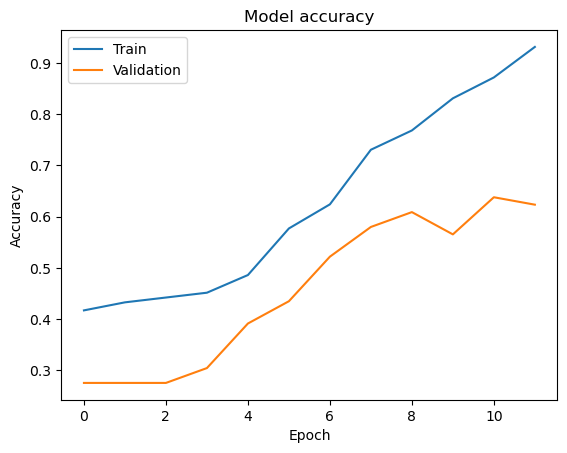

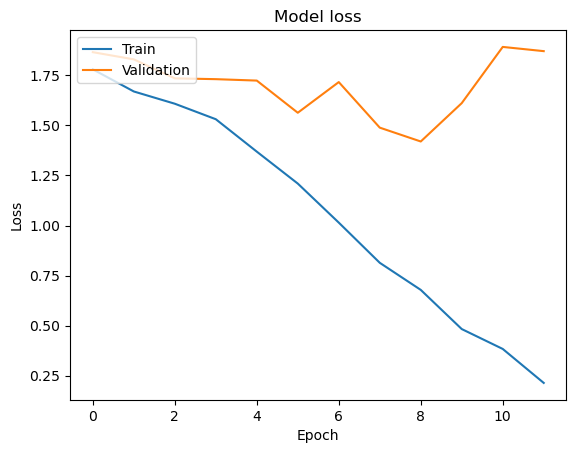

3/3 [==============================] - 1s 175ms/step


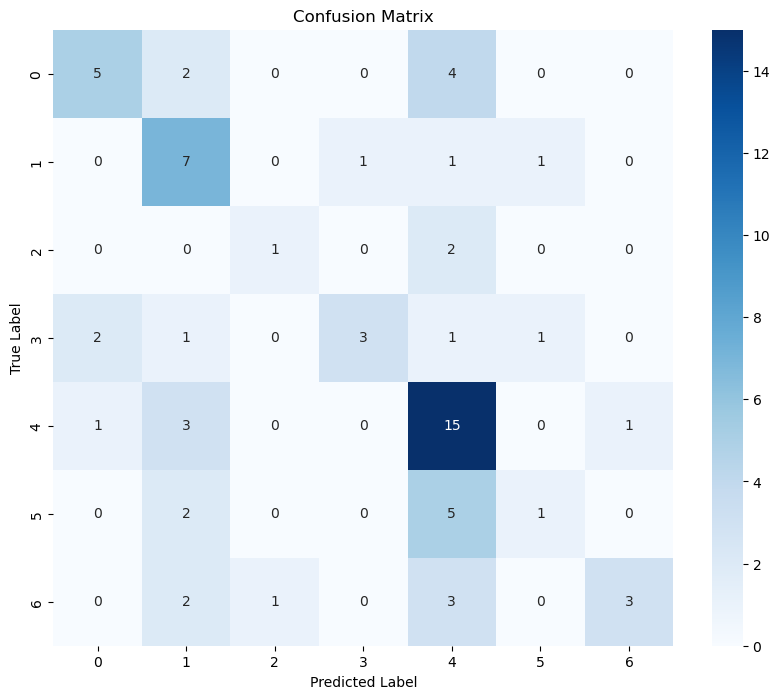

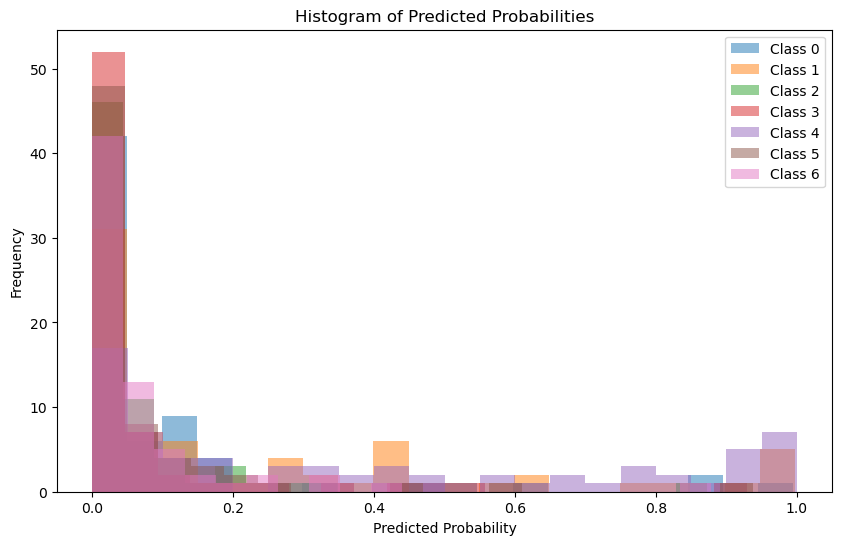

In [22]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


folder_path = 'SB-FishDisease'

subdirectories = [f.path for f in os.scandir(folder_path) if f.is_dir()]

file_paths = []
labels = []

for i, subdirectory in enumerate(subdirectories):
    image_files = [f.path for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith(('.png', '.jpg', '.jpeg'))]

    file_paths.extend(image_files)
    
    
    labels.extend([i] * len(image_files))
# CONVERSION
labels = np.array(labels)

target_size = (100, 100)  
# ARRAY
X_images = []
y_images = []

for file_path, label in zip(file_paths, labels):
    img = load_img(file_path, target_size=target_size)
    
    img_array = img_to_array(img)
    
    img_array /= 255.0
    
    X_images.append(img_array)
    y_images.append(label)


X_images = np.array(X_images)
y_images = np.array(y_images)

# Data splitting
X_train, X_temp, y_train, y_temp = train_test_split(X_images, y_images, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to categorical
num_classes = len(subdirectories)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # num_classes is the number of classes in your dataset
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

# Testing
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Heat map
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Histograph
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.hist(y_pred_probs[:, i], bins=20, alpha=0.5, label=f'Class {i}')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

